In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils.cinematica import *
from utils.player import MotorsController
import json

In [105]:
def get_route_positions(xi, zi, alphai, xf, zf, alphaf, divisions=20, plot=False):
    ri, thetai, oi = get_r_theta_o(xi, zi, alphai)
    rf, thetaf, of = get_r_theta_o(xf, zf, alphaf)

    deltaR = rf - ri
    deltaTheta = thetaf - thetai
    deltaO = of - oi

    x2i, z2i = get_pos_punta(xi, zi, alphai*pi/180)
    x_a, z_a, alpha_a = xi, zi, alphai

    x2f, z2f = get_pos_punta(xf, zf, alphaf*pi/180)

    dist = 0
    d = []
    x_points = []
    z_points = []
    alpha_points = []
    x2_points = []
    z2_points = []
    for n in range(divisions+1):
        xn, zn, alphan = get_x_z_alpha(ri + n*deltaR/divisions, thetai + n*deltaTheta/divisions, oi + n*deltaO/divisions)
        #print(ri + n*deltaR/N, thetai + n*deltaTheta/N, oi + n*deltaO/N)
        #print(get_r_theta_o(xn, zn, alphan))
        #print(alphan)
        x_points.append(round(xn,3))
        z_points.append(round(zn,3))
        alpha_points.append(round(alphan,3))
        if plot:
            x2, z2 = get_pos_punta(xn, zn, alphan*pi/180)
            x2_points.append(x2)
            z2_points.append(z2)
        dist += sqrt((xn - x_a)**2 + (zn - z_a)**2 + (alphan - alpha_a)**2)
        d.append(dist)
        x_a, z_a, alpha_a = xn, zn, alphan

    return x_points, z_points, alpha_points, d

def max_dist_rec(acc, dec, T):
    d_acc = (acc/2) * ((dec*T)/(acc+dec))**2
    d_dec = acc*(dec*T)/(acc+dec) * (T-(dec*T)/(acc+dec)) / 2
    dist_max = d_acc + d_dec
    return dist_max

def plan_speed_curve(d, acceleration, deceleration, T):
    speed = (acceleration*deceleration*T - sqrt(acceleration*deceleration*(acceleration*deceleration*T**2 - 2*acceleration*d - 2*deceleration*d))) / (acceleration+deceleration)
    t_acc = speed / acceleration
    t_dec = T - speed / deceleration
    return speed, t_acc, t_dec

def plan_temps_according_to_speed(distances, vel, t_acc, t_dec, acc, dec):
    d_t_acc = acc * t_acc**2 / 2
    d_t_dec = d_t_acc + vel * (t_dec - t_acc)
    temps = []
    for d_sum in distances:
        if d_sum < d_t_acc:
            temps.append(sqrt(2*d_sum/acc))
        elif d_sum < d_t_dec:
            temps.append((d_sum - d_t_acc)/vel + t_acc)
        else:
            a = dec / 2
            b = -(vel + (2*t_dec*dec)/2)
            c = d_sum - d_t_dec + vel*t_dec + (dec*t_dec**2)/2
            t = (-b - sqrt(round(b**2 - 4*a*c,3)))/(2*a)
            temps.append(t)
    return temps

def x_mm_to_units(mm):
    return int(mm * 1000 / 8 )

def x_units_to_mm(units):
    return units * 8 / 1000
    
def z_mm_to_units(mm):
    return int(mm * 1000 / 8 )

def z_units_to_mm(units):
    return units * 8 / 1000
    
def alpha_angle_to_units(angle):
    return int(angle * 10000 / 360)

def alpha_units_to_angle(units):
    return units * 360 / 10000
    
def plan_route(x_points, z_points, alpha_points, temps):
    points = {'x': [], 'z': [], 'alpha': [], 't': []}

    for i in range(len(x_points) - 1):
        x = x_mm_to_units(x_points[i])            
        z = z_mm_to_units(z_points[i])
        alpha = alpha_angle_to_units(alpha_points[i])
        t = temps[i]

        points['x'].append(x)
        points['z'].append(z)
        points['alpha'].append(alpha)
        points['t'].append(t)

    return points
        
def get_route_a_b(initial_state, final_state, acc=20, dec=20, T=None, divisions=12):
    x_points, z_points, alpha_points, d = get_route_positions(*initial_state.cart_coords(), *final_state.cart_coords(), divisions=divisions, plot=False)
    if not T:
        T = 0.1
        while True:
            if not max_dist_rec(acc, dec, T) < d[-1]:
                break
            T += 0.1
        T = T*2
    else:
        if max_dist_rec(acc, dec, T) < d[-1]:
            print(f'Impossible to achieve such position with given acceleration and deceleration. {d[-1]} > {max_dist_rec(acc, dec, T)}')
            return None
    vel, t_acc, t_dec = plan_speed_curve(d[-1], acc, dec, T)
    temps = plan_temps_according_to_speed(d, vel, t_acc, t_dec, acc, dec)
    route = plan_route(x_points, z_points, alpha_points, temps)
    route['x'].append(x_mm_to_units(final_state.x))
    route['z'].append(z_mm_to_units(final_state.z))
    route['alpha'].append(alpha_angle_to_units(final_state.alpha))
    route['t'].append(T)
    return route

def get_route_complete(path):
    with open(path) as file:
        data = json.load(file)
    
    #state_at_begining = State(*get_r_theta_o(x,z,alpha), 0)
    initial_state = State(data['init_pos']['r'], data['init_pos']['theta'], data['init_pos']['offset'], 0)

    route = {'x': [x_mm_to_units(initial_state.x)],
             'z': [z_mm_to_units(initial_state.z)],
             'alpha': [alpha_angle_to_units(initial_state.alpha)],
             'flow': [0],
             't': [0]} #get_route_a_b(state_at_begining, initial_state, acc=20, dec=20, T=None, divisions=200)

    for act in data['phrase']:
        if act['move']:
            x = x_units_to_mm(route['x'][-1])
            z = z_units_to_mm(route['z'][-1])
            alpha = alpha_units_to_angle(route['alpha'][-1])
            a = State(*get_r_theta_o(x, z, alpha), 0)
            b = State(act['r'], act['theta'], act['offset'], act['flow'])
            route_add = get_route_a_b(a, b, acc=act['acceleration'], dec=act['deceleration'], T=act['time'], divisions=int(act['time']*100))

            Fi = route['flow'][-1]
            Ff = act['flow']
            t  = route['t'][-1]
            ti = t
            T  = act['time']
            deformation = act['deformation']
            vibrato_amp = act['vibrato_amp']
            vibrato_freq = act['vibrato_freq']

            for i in range(len(route_add['t'])):
                route_add['t'][i] = route_add['t'][i] + ti
                ramp = Fi + (Ff-Fi) * ((t-ti) / T) ** deformation
                vibr = ramp * vibrato_amp * sin(t * 2*pi * vibrato_freq)
                flow_sat = max(0,min(50, ramp+vibr))
                route['flow'].append(flow_sat)
                t += 0.01


            route['x'] += route_add['x']
            route['z'] += route_add['z']
            route['alpha'] += route_add['alpha']
            route['t'] += route_add['t']
        else:
            t = route['t'][-1]
            T  = act['time']
            Fi = act['flow']
            vibrato_amp = act['vibrato_amp']
            vibrato_freq = act['vibrato_freq']
            for i in range(int(T*100)):
                t += 0.01
                vibr = Fi * vibrato_amp * sin(t * 2*pi * vibrato_freq)
                flow_sat = max(0,min(50, Fi+vibr))
                route['flow'].append(flow_sat)
                route['x'].append(route['x'][-1])
                route['z'].append(route['z'][-1])
                route['alpha'].append(route['alpha'][-1])
                route['t'].append(t)
                
    
    route['x_vel'] = []
    route['z_vel'] = []
    route['alpha_vel'] = []
    
    for i in range(len(route['t']) - 1):
        route['x_vel'].append(int((route['x'][i + 1] - route['x'][i]) / route['t'][i + 1] - route['t'][i]))
        route['z_vel'].append(int((route['z'][i + 1] - route['z'][i]) / route['t'][i + 1] - route['t'][i]))
        route['alpha_vel'].append(int((route['alpha'][i + 1] - route['alpha'][i]) / route['t'][i + 1] - route['t'][i]))
    route['x_vel'].append(0)
    route['z_vel'].append(0)
    route['alpha_vel'].append(0)

    return route

def get_value_from_func(t, func):
    t_val = min(int((len(func) - 1) * t / func[-1][0]), len(func) - 1)
    if t < func[t_val][0]:
        while t < func[t_val][0]:
            t_val -= 1
            if t_val < 0:
                return func[0][1]
        return round(func[t_val][1] + ((t - func[t_val][0]) / (func[t_val + 1][0] - func[t_val][0])) * (func[t_val + 1][1] - func[t_val][1]))
    else:
        while t > func[t_val][0]:
            t_val += 1
            if t_val >= len(func):
                return func[-1][1]
        return round(func[t_val - 1][1] + ((t - func[t_val - 1][0]) / (func[t_val][0] - func[t_val - 1][0])) * (func[t_val][1] - func[t_val - 1][1]))

In [102]:
path = '/home/fernando/Dropbox/UC/Magister/robot-flautista/examples/escala_1.json'
route = get_route_complete(path)

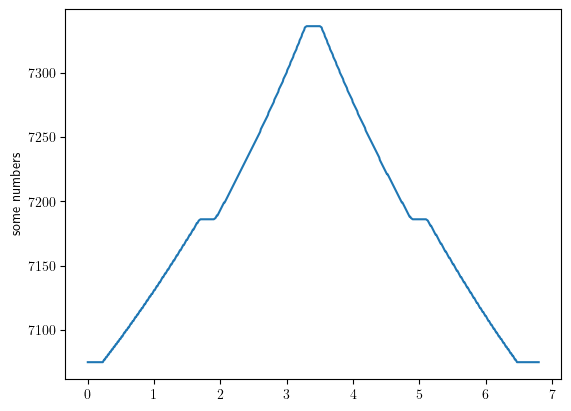

In [103]:
plt.plot(route['t'], route['x'])
plt.ylabel('some numbers')
plt.show()

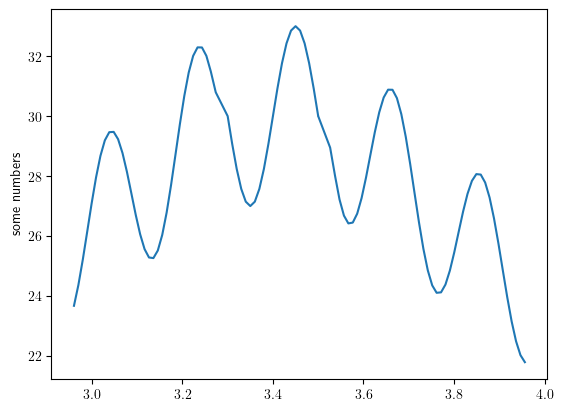

In [104]:
plt.plot(route['t'][300:400], route['flow'][300:400])
plt.ylabel('some numbers')
plt.show()

In [3]:
stateA = State(15,45,0,0)
stateB = State(9,41,0.5,10)

r = get_route(stateA, stateB, acc=35, dec=35, T=1, divisions=40)

ValueError: x and y must have same first dimension, but have shapes (687,) and (681,)

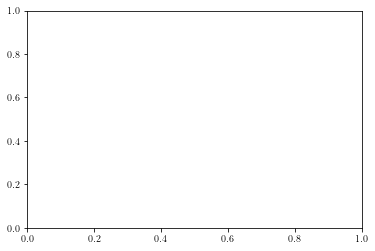

In [3]:
plt.plot(r['t'], r['x'])
plt.ylabel('some numbers')
plt.show()

In [80]:
with open('/home/fernando/Dropbox/UC/Magister/robot-flautista/examples/escala.json') as file:
    data = json.load(file)

In [9]:
x = []
z = []
alpha = []
for i in range(len(r['t'])):
    x.append((r['t'][i], r['x'][i]))
    z.append((r['t'][i], r['z'][i]))
    alpha.append((r['t'][i], r['alpha'][i]))

In [90]:
def get_value_from_func(t, func):
    t_val = min(int((len(func) - 1) * t / func[-1][0]), len(func) - 1)
    if t < func[t_val][0]:
        while t < func[t_val][0]:
            t_val -= 1
            if t_val < 0:
                return func[0][1]
        return round(func[t_val][1] + ((t - func[t_val][0]) / (func[t_val + 1][0] - func[t_val][0])) * (func[t_val + 1][1] - func[t_val][1]))
    else:
        while t > func[t_val][0]:
            t_val += 1
            if t_val >= len(func):
                return func[-1][1]
        return round(func[t_val - 1][1] + ((t - func[t_val - 1][0]) / (func[t_val][0] - func[t_val - 1][0])) * (func[t_val][1] - func[t_val - 1][1]))

In [91]:
get_value_from_func(1.95, x)

7012

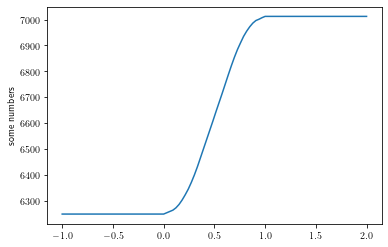

In [93]:
ts = linspace(-1, 2, 100)
xs = [get_value_from_func(i, x) for i in ts]
plt.plot(ts, xs)
plt.ylabel('some numbers')
plt.show()

In [55]:
xs

[6250,
 6254,
 6259,
 6263,
 6267,
 6277,
 6288,
 6303,
 6319,
 6337,
 6358,
 6380,
 6406,
 6433,
 6463,
 6492,
 6522,
 6552,
 6581,
 6611,
 6641,
 6671,
 6700,
 6730,
 6760,
 6790,
 6820,
 6856,
 6881,
 6911,
 6939,
 6962,
 6990,
 7001,
 7016,
 7028,
 7043,
 7042,
 7043,
 7012]